# **Cars 4 You | Machine Learning Project**

### **Import Libraries**

In [77]:
!pip install category_encoders
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer
from rapidfuzz import process, fuzz
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.preprocessing import StandardScaler


In [30]:
# Canonical values of fuel_type and transmission
canonical_fuels = ['petrol', 'diesel', 'hybrid', 'electric', 'other']
canonical_transmissions = ['manual', 'automatic', 'semi-auto', 'other']

# Normalize column strings
df['fuel_type_clean'] = (df['fuelType']
    .astype(str)
    .str.strip()
    .str.lower()
)
df['transmission_clean'] = (df['transmission']
    .astype(str)
    .str.strip()
    .str.lower()
)

# Correcting typos in the columns
def fuzzy_match_column(series, canonical_values, score_cutoff=85, default='other'):
    """
    Fuzzy-matches each value in a pandas Series to a list of canonical values.
    Example:
        fuzzy_match_column(df['fuel_type_clean'], ['petrol', 'diesel', 'electric'])
    """
    def match_one(value):


        # exact match
        if value in canonical_values:
            return value

        # fuzzy match
        match = process.extractOne(value, canonical_values, scorer=fuzz.token_sort_ratio)
        if match is None:
            return "unknown"

        best_choice, score, _ = match
        return best_choice if score >= score_cutoff else default

    return series.apply(match_one)


# apply fix functions
df['fuel_type_fixed'] = fuzzy_match_column(df['fuel_type_clean'], canonical_fuels)
df['transmission_fixed'] = fuzzy_match_column(df['transmission_clean'], canonical_transmissions)


# final result
df[['fuelType', 'fuel_type_clean', 'fuel_type_fixed',
    'transmission', 'transmission_clean', 'transmission_fixed']].head(10)


# drop and rename
df.drop(columns= ['fuelType', 'fuel_type_clean', 'transmission','transmission_clean'], inplace= True)

df = df.rename(columns={'fuel_type_fixed': 'fuel_type', 'transmission_fixed': 'transmission'})

### **Duplicates**

First thing first, lets check if we have duplicate ids

In [31]:
df['carID'][df['carID'].duplicated()]

Series([], Name: carID, dtype: int64)

AS we see, theres no duplicated ids

In [32]:
df[df.duplicated(keep=False)]

,carID,year,price,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,model,brand,fuel_type,transmission


No duplicated rows as well

### **Fix Column Names**

In [33]:
# change order of columns
df = df[['carID','brand', 'model', 'year', 'transmission', 'mileage', 'fuel_type', 'tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners', 'price']]

In [34]:
# rename column cardid to car_id and brand fixed to brand
df = df.rename(columns={'carID': 'car_id', 'engineSize': 'engine_size', 'paintQuality%': 'paint_quality', 'previousOwners': 'previous_owners'})

In [35]:
df.head()

,car_id,brand,model,year,transmission,mileage,fuel_type,tax,mpg,engine_size,paint_quality,previous_owners,price
0,69512,volkswagen,golf,2016,semi-auto,28421,petrol,102.33,11.42,2.0,63,4,22290
1,53000,toyota,yaris,2019,manual,4589,petrol,145.00,47.90,1.5,50,1,13790
2,6366,audi,q3,2019,semi-auto,3624,petrol,145.00,40.90,1.5,56,4,24990
3,29021,ford,fiesta,2018,manual,9102,petrol,145.00,65.70,1.0,50,2,12500
4,10062,bmw,2 series,2019,manual,1000,petrol,145.00,42.80,1.5,97,3,22995


---

## **More EDA**

C:\Users\ashul\AppData\Local\Temp\ipykernel_37016\4190273431.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="viridis", ax=axes[i])
C:\Users\ashul\AppData\Local\Temp\ipykernel_37016\4190273431.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="viridis", ax=axes[i])


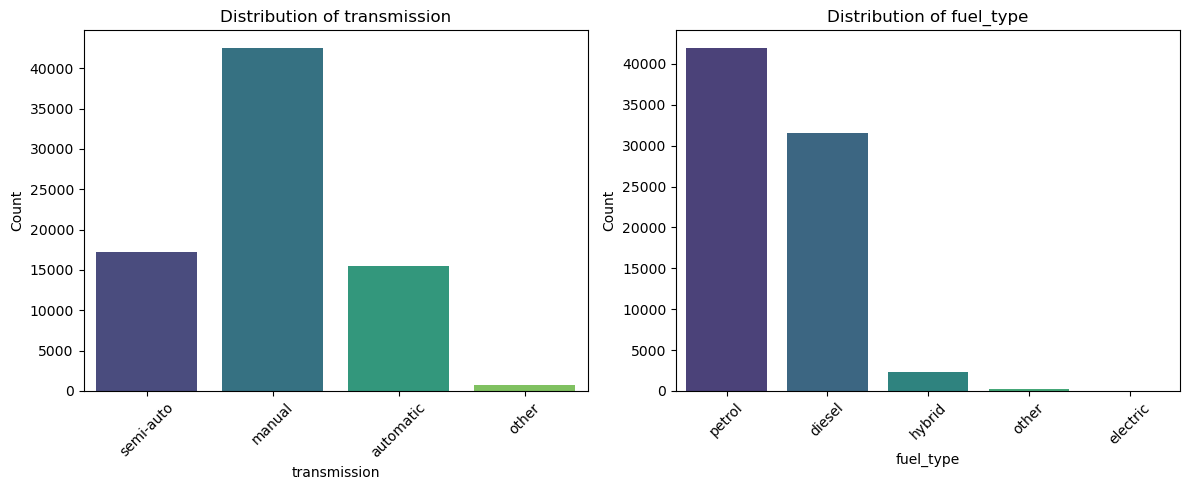

In [36]:
cat_features = ['transmission', 'fuel_type']

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

for i, col in enumerate(cat_features):
    sns.countplot(data=df, x=col, palette="viridis", ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


We will set 'other' as NaN values and fill it again with the RFC model.  
For the fuel_type, we will merge the 'hybrid' and 'electric' to 'other' 

---

## **Outliers**

### **Bi-variate Analysis**

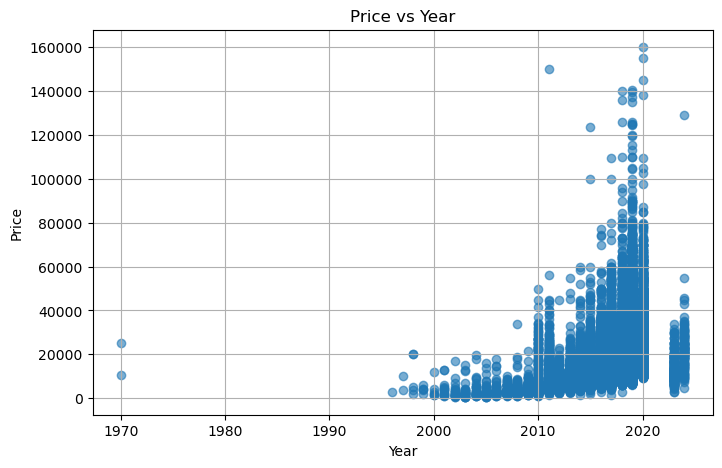

In [37]:
plt.figure(figsize=(8,5))
plt.scatter(df['year'], df['price'], alpha=0.6)
plt.title('Price vs Year')
plt.xlabel('Year')
plt.ylabel('Price')
plt.grid(True)
plt.show()

**Price vs year**  
- newer cars (2016–2024) have much higher prices and wider spread, wwhich's normal
- older cars (before 2005) - a few have prices above £20,000–£40,000, but most of them are concentrated at price under £20,000
- **Drop cars with year < 1990 as this value doesn't make sense**

In [38]:
# drop cars with year < 1990
df = df[df['year'] >= 1990]

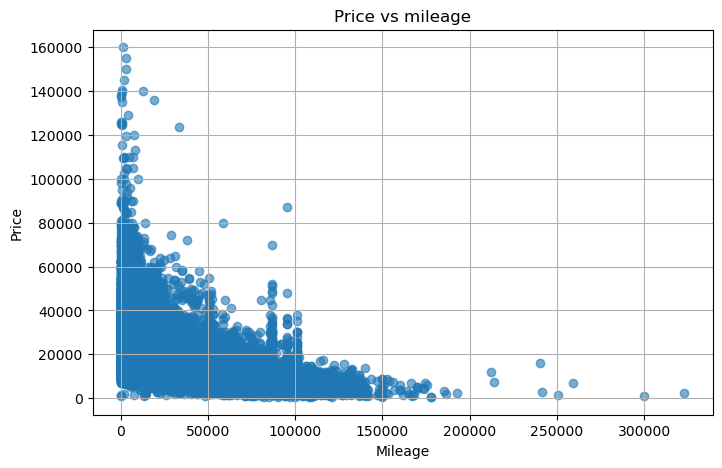

In [39]:
plt.figure(figsize=(8,5))
plt.scatter(df['mileage'], df['price'], alpha=0.6)
plt.title('Price vs mileage')
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.grid(True)
plt.show()

**Price vs mileage**
- negative correlation - higher mileage = lower price.
- A few low-mileage cars with very low prices - quite reasonable prices for the models, high prices - better and newer cars
- A few high-mileage cars (>200,000–250,000 km) still make sense as price is reasonably low for them

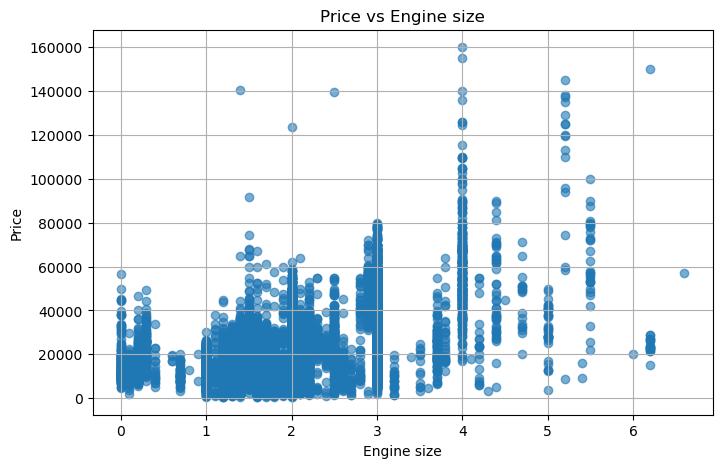

In [40]:
plt.figure(figsize=(8,5))
plt.scatter(df['engine_size'], df['price'], alpha=0.6)
plt.title('Price vs Engine size')
plt.xlabel('Engine size')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [41]:
# Show cars that are too expensive for small engines
print("Cars with price > 120000 and engine_size < 3.0:")
display(df[(df["price"] > 120000) & (df["engine_size"] < 3.0)])

# Show cars that are too cheap for big engines
print("\nCars with engine_size > 5.0 and price < 25000:")
display(df[(df["engine_size"] > 5.0) & (df["price"] < 25000)])

Cars with price > 120000 and engine_size < 3.0:


,car_id,brand,model,year,transmission,mileage,fuel_type,tax,mpg,engine_size,paint_quality,previous_owners,price
15364,41265,mercedes,a class,2019,semi-auto,1000,petrol,145.0,22.1,2.5,37,4,139559
34018,43994,mercedes,a class,2019,semi-auto,785,petrol,150.0,22.1,1.4,64,0,140319
44022,13374,bmw,2 series,2015,semi-auto,33419,diesel,20.0,68.9,2.0,42,3,123456



Cars with engine_size > 5.0 and price < 25000:


,car_id,brand,model,year,transmission,mileage,fuel_type,tax,mpg,engine_size,paint_quality,previous_owners,price
4049,38980,mercedes,c class,2013,semi-auto,43442,petrol,280.00,41.52,6.2,76,0,23000
5047,46372,mercedes,c class,2013,semi-auto,49964,petrol,397.21,23.00,6.2,78,3,22995
14216,35612,mercedes,c class,2013,automatic,52396,petrol,570.00,23.50,6.2,44,2,23990
20432,35538,mercedes,c class,2010,semi-auto,49964,petrol,326.03,32.62,6.2,58,3,22995
20916,44937,mercedes,c class,2013,automatic,41866,petrol,570.00,23.50,6.2,80,0,21999
23239,3167,audi,a6,2006,automatic,98000,petrol,570.00,21.10,5.2,93,0,8750
24327,46536,mercedes,c class,2013,automatic,44000,petrol,225.00,39.18,6.2,88,2,23990
29612,45353,mercedes,cl class,2002,automatic,77000,petrol,325.00,21.10,5.4,42,2,8995
39475,37825,mercedes,e class,2008,semi-auto,55000,petrol,570.00,19.80,6.2,70,1,14995
41101,40094,mercedes,c class,2013,automatic,39000,petrol,392.00,29.02,6.2,89,1,22948


**Price vs Engine Size**
- As we can see for cars with engine size <3 price is unreasonably high, as a normal price for these cars is around 20-30000
- Also cars with too high engine size aren't within normal range as normally cars of these models have 2-3L, but the price is quite normal
- We will also remove entries where engine size > 6, as these cars are very rare and don't make sense in a real world scenario
- **So, we will consider both of these categories as outliers as the values don't make sense ina real world**

In [42]:
# remove entries where engine size < 3 and price > 120000
df = df[(df['engine_size'] >= 3) | (df['price'] <= 120000)]

# remove entries where engine size > 5 and price < 25000
df = df[(df['engine_size'] <= 5) | (df['price'] >= 25000)]

# remove entries where engine size > 6
df = df[df['engine_size'] <= 6]


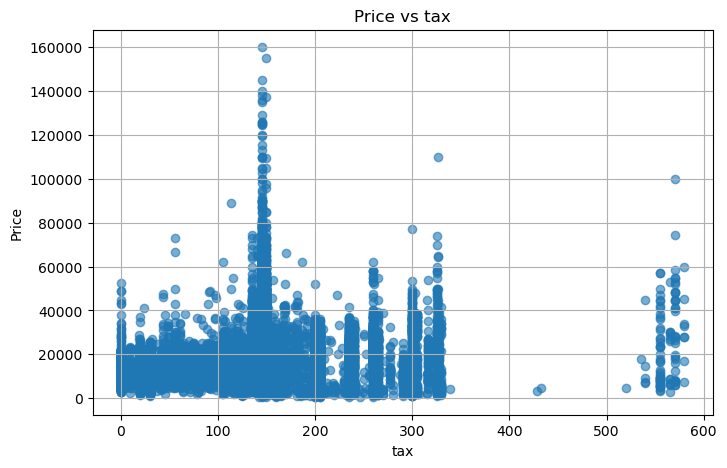

In [43]:
plt.figure(figsize=(8,5))
plt.scatter(df['tax'], df['price'], alpha=0.6)
plt.title('Price vs tax')
plt.xlabel('tax')
plt.ylabel('Price')
plt.grid(True)
plt.show()

**Price vs tax**
- We can see some outliers that sit under the 300 and 500 tax range, where that range is not common for most cars

In [44]:
# remove entries where tax is in the range of 350 and 500
df = df[(df['tax'] < 350) | (df['tax'] > 500)]

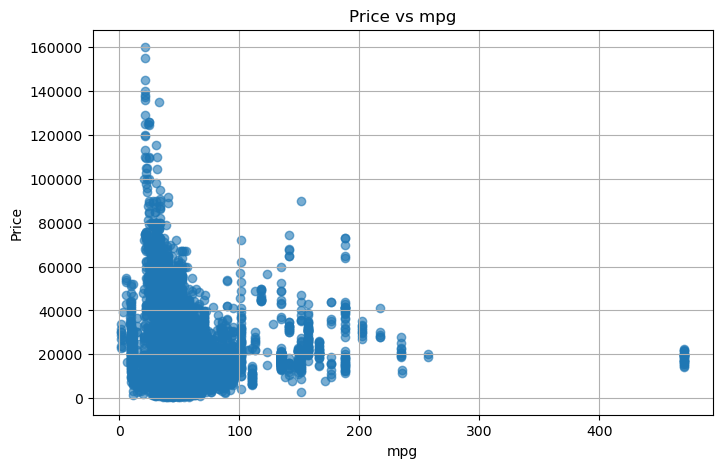

In [45]:
plt.figure(figsize=(8,5))
plt.scatter(df['mpg'], df['price'], alpha=0.6)
plt.title('Price vs mpg')
plt.xlabel('mpg')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [46]:
# --- Check strange combinations between price and mpg ---
print("\nCars with extremely high mpg but very low price:")
display(df[(df["mpg"] > 300) & (df["price"] < 25000)])


Cars with extremely high mpg but very low price:


,car_id,brand,model,year,transmission,mileage,fuel_type,tax,mpg,engine_size,paint_quality,previous_owners,price
4101,13075,bmw,i3,2015,automatic,33931,hybrid,0.0,470.8,0.0,31,4,15498
5278,12640,bmw,i3,2017,automatic,23956,other,135.0,470.8,0.6,53,1,19500
6978,12786,bmw,i3,2015,automatic,29465,electric,0.0,470.8,3.8,67,2,17400
18261,8993,bmw,i3,2016,automatic,9990,hybrid,0.0,470.8,0.0,44,0,18999
18710,12853,bmw,i3,2017,automatic,10839,hybrid,0.0,470.8,0.0,31,4,21898
21445,12090,bmw,i3,2016,automatic,8421,hybrid,0.0,470.8,0.0,31,4,19490
24975,13378,bmw,i3,2015,automatic,9886,hybrid,0.0,470.8,0.0,44,0,17481
29581,12269,bmw,i3,2017,automatic,26965,hybrid,140.0,470.8,0.0,81,3,19980
33383,10695,bmw,i3,2017,automatic,23883,hybrid,135.0,470.8,0.0,54,1,21494
33829,11532,bmw,i3,2016,automatic,35446,hybrid,0.0,470.8,0.0,59,3,16500


**Price vs mpg**
- Cars with extremely high mpg but very low price are all from the same car model, so we will keep it as it can be unique for car model

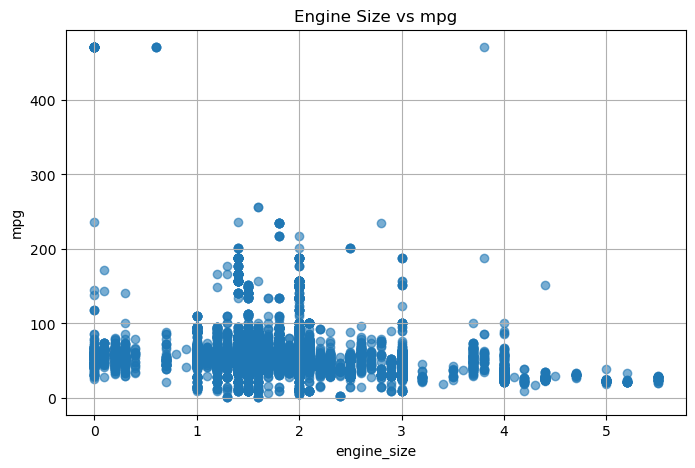

In [47]:
plt.figure(figsize=(8,5))
plt.scatter(df['engine_size'], df['mpg'], alpha=0.6)
plt.title('Engine Size vs mpg')
plt.xlabel('engine_size')
plt.ylabel('mpg')
plt.grid(True)
plt.show()

**Engine Size vs mpg**
- Cars with high engine size tend to have lower mpg, which is expected
- However, there are some outliers with high engine size and high mpg, which is not expected

In [48]:
# remove entries where engine size is above 3 and mpg is above 300
df = df[~((df['engine_size'] > 3) & (df['mpg'] > 300))]


### **Boxplots**

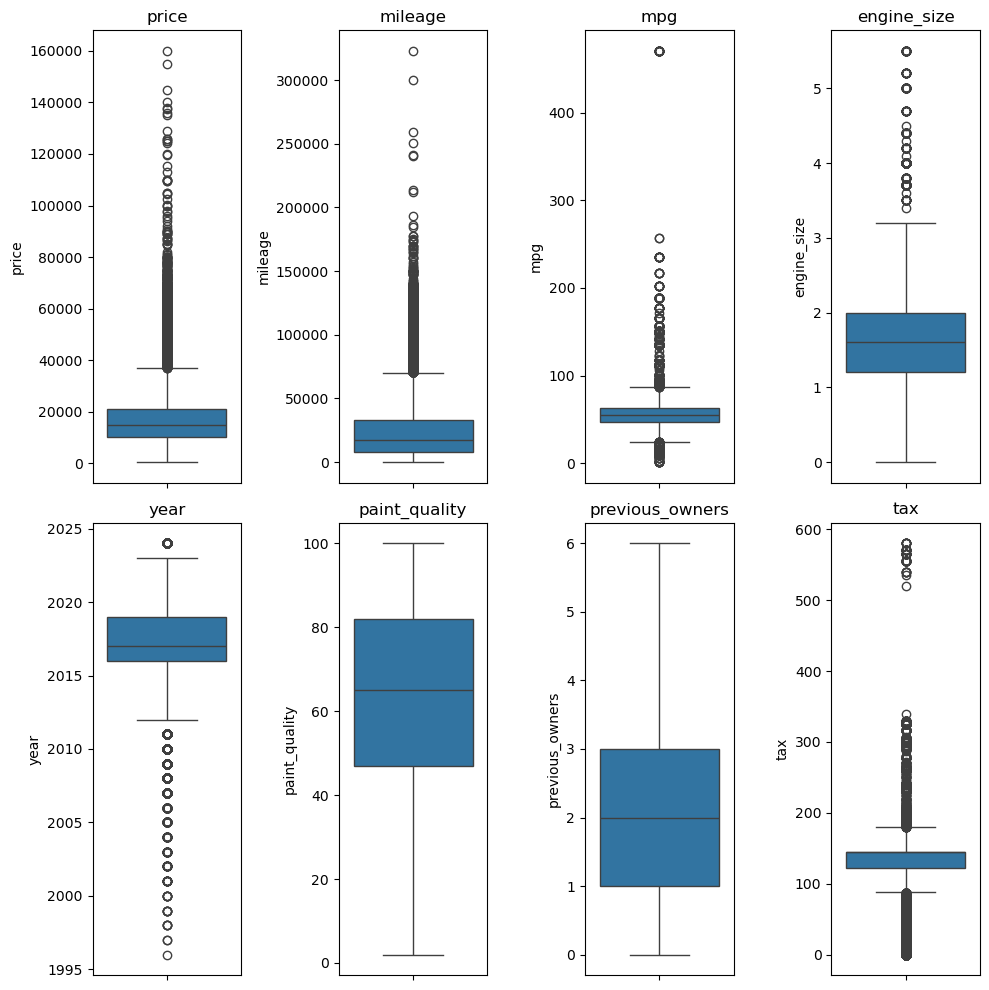

In [49]:
fig, axes = plt.subplots(2, 4, figsize=(10, 10))
axes = axes.flatten()  # makes it a 1D array of length 6

sns.boxplot(df["price"], ax=axes[0])
axes[0].set_title("price")

sns.boxplot(df["mileage"], ax=axes[1])
axes[1].set_title("mileage")

sns.boxplot(df["mpg"], ax=axes[2])
axes[2].set_title("mpg")

sns.boxplot(df["engine_size"], ax=axes[3])
axes[3].set_title("engine_size")

sns.boxplot(df["year"], ax=axes[4])
axes[4].set_title("year")

sns.boxplot(df["paint_quality"], ax=axes[5])
axes[5].set_title("paint_quality")

sns.boxplot(df["previous_owners"], ax=axes[6])
axes[6].set_title("previous_owners")

sns.boxplot(df["tax"], ax=axes[7])
axes[7].set_title("tax")

plt.tight_layout()
plt.show()

---

## **Feature Engineering**

### **Feature Enrichment**

we have an idea to extract the horsepower and the number of gears from the external dataset. we will do that in the final delivery if so  
https://sesjournal.org/index.php/1/article/view/104/724

### **Feature Selection**

for the feature selection, we will first make an analysis for the categorical classes and check if we have any categorical feature where the average price is more or less the same for every class. After, we will check the correlation heatmap to see if we have any redundant feature and lastly we will perform some feature elimination methods. Based on each steps results, we will decide which features to keep for the model.


C:\Users\ashul\AppData\Local\Temp\ipykernel_37016\2478026143.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


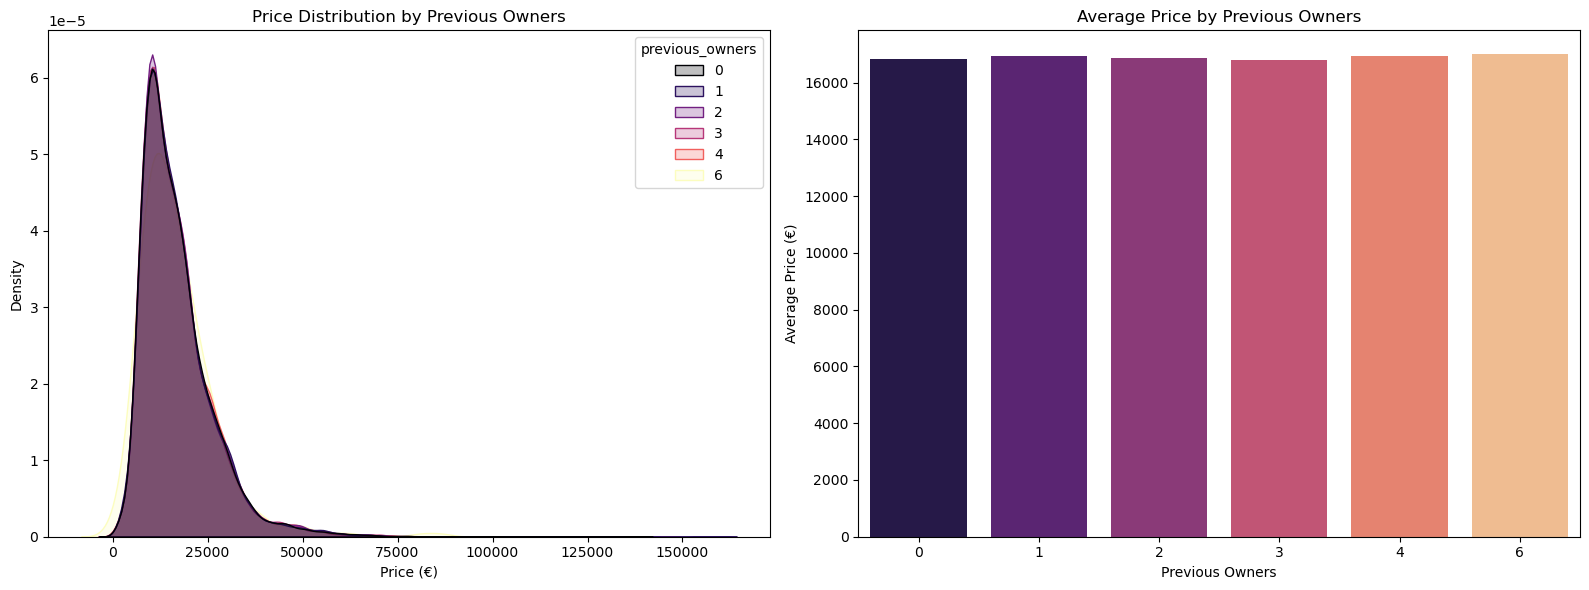

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))

# --- Left: KDE plot ---
sns.kdeplot(
    data=df,
    x='price',
    hue='previous_owners',
    palette="magma",
    fill=True,
    common_norm=False,
    ax=axes[0]
)
axes[0].set_title("Price Distribution by Previous Owners")
axes[0].set_xlabel("Price (€)")
axes[0].set_ylabel("Density")

# --- Right: Average price bar plot ---
avg_price = df.groupby('previous_owners')['price'].mean().sort_index()
sns.barplot(
    x=avg_price.index,
    y=avg_price.values,
    palette="magma",
    ax=axes[1]
)
axes[1].set_title("Average Price by Previous Owners")
axes[1].set_xlabel("Previous Owners")
axes[1].set_ylabel("Average Price (€)")

plt.tight_layout()
plt.show()

The average price remains almost constant across different numbers of previous owners, indicating that ownership history has little to no direct impact on price.  
For that reason we will probably drop this feature from our df

C:\Users\ashul\AppData\Local\Temp\ipykernel_37016\3228626493.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_price.index, y=avg_price.values, palette="viridis", ax=axes[i])
C:\Users\ashul\AppData\Local\Temp\ipykernel_37016\3228626493.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_price.index, y=avg_price.values, palette="viridis", ax=axes[i])
C:\Users\ashul\AppData\Local\Temp\ipykernel_37016\3228626493.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_price.index, y=avg_price.values, palette="viridis", ax=axes

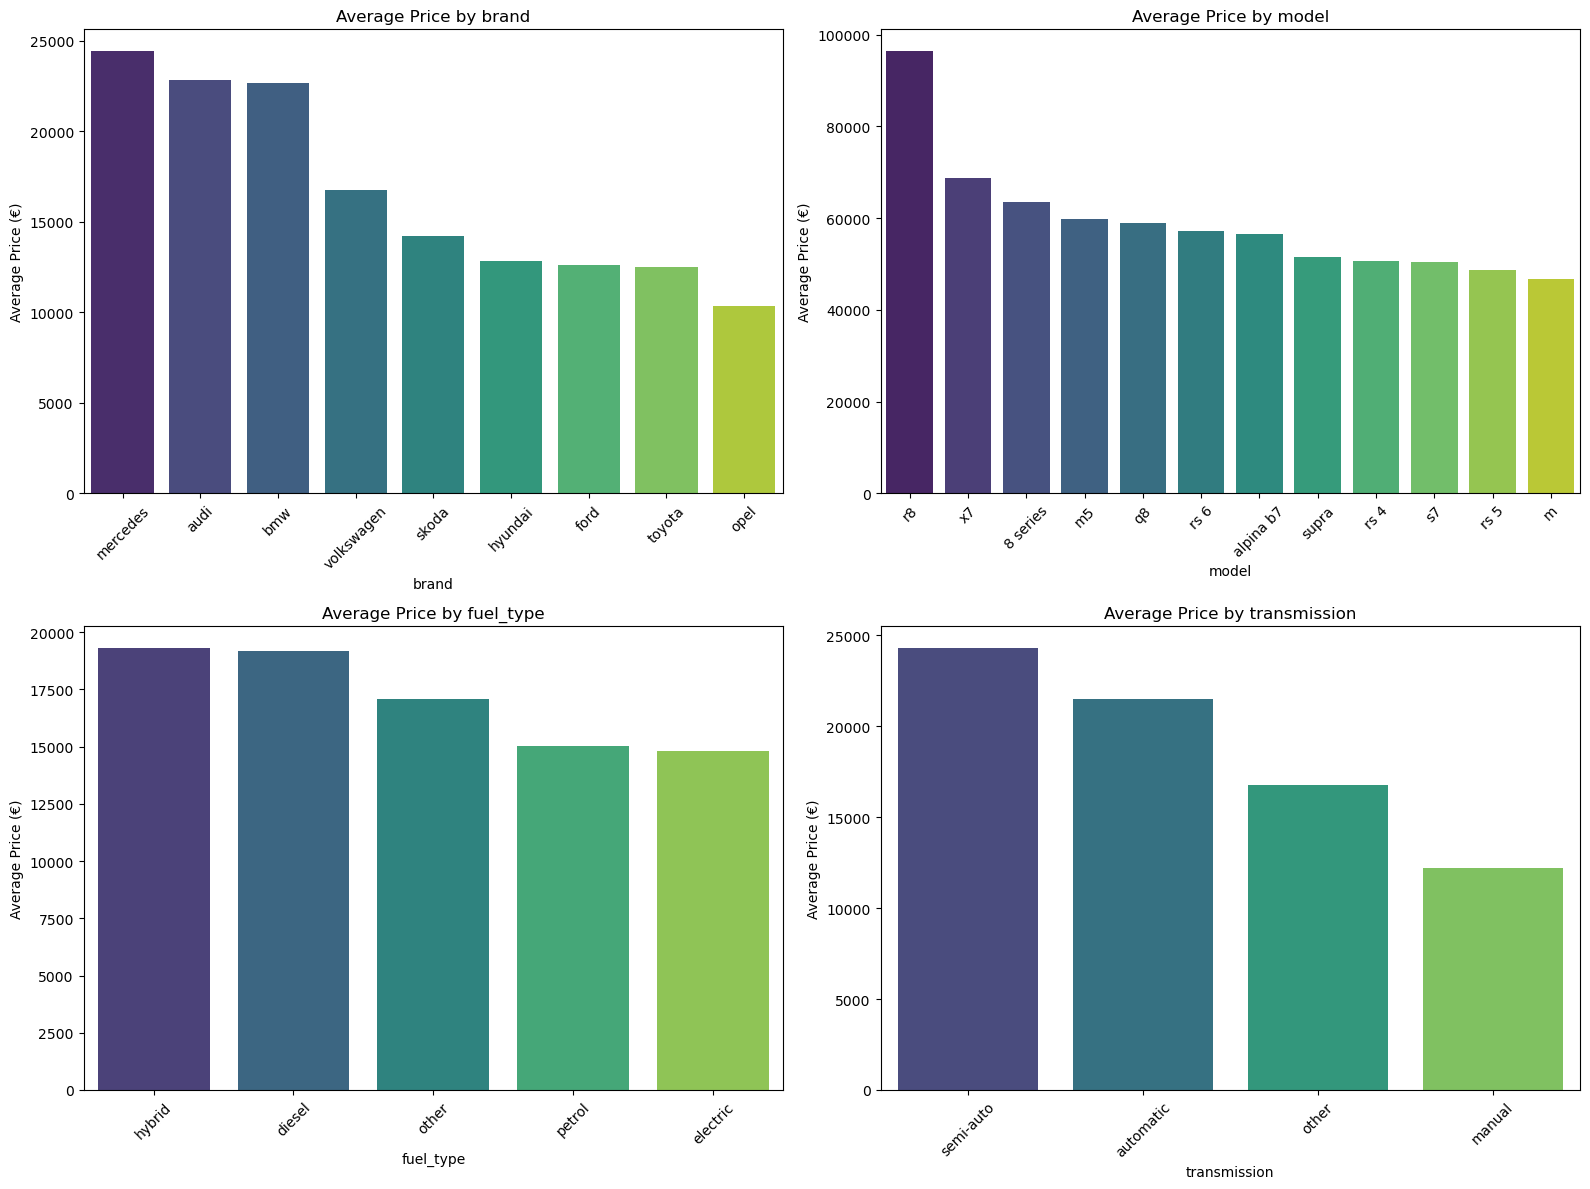

In [51]:
cat_cols = [c for c in ['brand','model','fuel_type','transmission'] if c in df.columns]
TOP_N = 12

fig, axes = plt.subplots(2, 2, figsize=(16,12))  # 2 rows, 2 cols
axes = axes.flatten()  # make it 1D for easy indexing

for i, col in enumerate(cat_cols):
    # Calculate the average price per category and select the top N
    avg_price = df.groupby(col)['price'].mean().sort_values(ascending=False).head(TOP_N)
    
    sns.barplot(x=avg_price.index, y=avg_price.values, palette="viridis", ax=axes[i])
    axes[i].set_title(f"Average Price by {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Average Price (€)")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

all the other categorical features have a clear impact on the price, since we have some difference in the average price for each category.

#### **Correlation Heatmap**

In [52]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

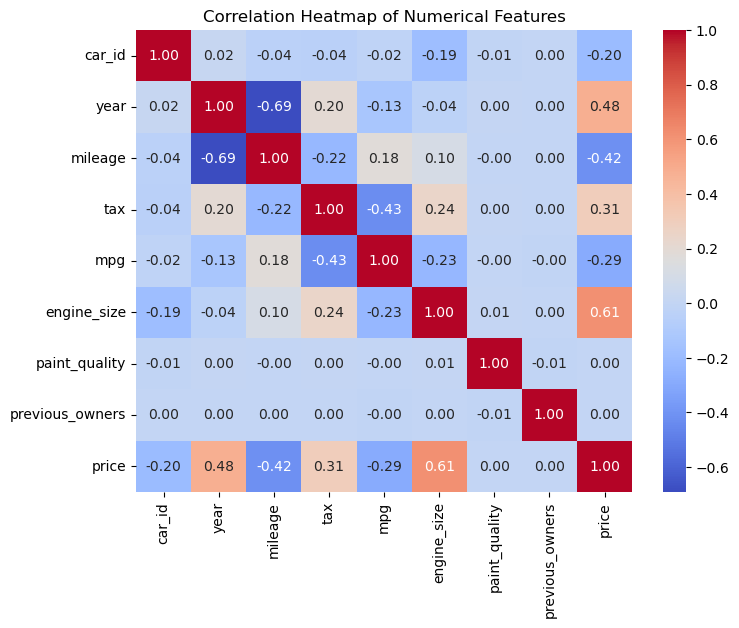

In [53]:
# Compute correlation matrix
corr_matrix = df[num_cols].corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

There are no redundant features in the dataset.  
Paint Quality and Previous Owners dont have any correlation with the price, we will probably remove them from the dataset.

#### **feature elimination methods here**

#### **feature manipulation**

as we said earlier, we will merge the 'eletric' and 'hybrid' fuel types to 'other' fuel type, since they are not that common

In [54]:
# merge 'eletric' and 'hybrid' fuel types to 'other' fuel type
df['fuel_type'] = df['fuel_type'].replace(['electric', 'hybrid'], 'other')

we will also turn the year into age of the car, for convenience

In [55]:
# turn year into age of the car using datetime
df['age'] = datetime.now().year - df['year']
df.drop('year', axis=1, inplace=True)

and we will set the 'other' values in transmission to NaN and fill it again with the RFC model.

In [56]:
# set 'other' as NaN values in transmission
df['transmission'] = df['transmission'].replace('other', np.nan)

# fill NaN values in transmission with the RFC model
df= impute_categorical_rfc(df, 'transmission', ignore_cols=['car_id', 'price'])

       mileage     tax    mpg  engine_size  paint_quality  previous_owners  \
0        28421  102.33  11.42          2.0             63                4   
1         4589  145.00  47.90          1.5             50                1   
2         3624  145.00  40.90          1.5             56                4   
3         9102  145.00  65.70          1.0             50                2   
4         1000  145.00  42.80          1.5             97                3   
...        ...     ...    ...          ...            ...              ...   
75968    14480  125.00  53.30          2.0             78                0   
75969    52134  200.00  47.90          2.0             38                2   
75970    11304  145.00  67.00          1.0             57                3   
75971    69072  125.00  60.10          2.0             74                2   
75972    16709  145.00  64.20          1.1             38                1   

       age  brand_bmw  brand_ford  brand_hyundai  ...  model_x7

---

## **Encoding**

**fuel_type (5 categories)** → One-Hot Encoding (OHE)

**brand (9 categories)** → One-Hot Encoding (OHE)

**transmission (4 categories)** → One-Hot Encoding (OHE)

**model (10 + categories)** → Target Encoding with K-Fold (pre defined)

In [57]:
df_encoded = df.copy()

In [58]:
# One-Hot Encoding for brand
brand_dummies = pd.get_dummies(df['brand'], prefix='brand', drop_first=False).astype(int)
df_encoded = pd.concat([df_encoded, brand_dummies], axis=1)

# One-Hot Encoding for fuel_type
fuel_dummies = pd.get_dummies(df['fuel_type'], prefix='fuel', drop_first=False).astype(int)
df_encoded = pd.concat([df_encoded, fuel_dummies], axis=1)

# One-Hot Encoding for transmission
trans_dummies = pd.get_dummies(df['transmission'], prefix='trans', drop_first=False).astype(int)
df_encoded = pd.concat([df_encoded, trans_dummies], axis=1)

In [59]:
# Compute average price per brand and model
avg_price_lookup = df.groupby(['brand', 'model'])['price'].mean().reset_index()
avg_price_lookup.rename(columns={'price':'avg_price'}, inplace=True)

# Save to CSV
avg_price_lookup.to_csv('../data/avg_price_brand_model.csv', index=False)

In [60]:
# Read the precomputed averages
avg_price_lookup = pd.read_csv('../data/avg_price_brand_model.csv')

# Merge with the original dataframe
df_encoded = df_encoded.merge(avg_price_lookup, on=['brand','model'], how='left')

In [61]:
df_encoded = df_encoded.drop(columns=['fuel_type', 'brand', 'transmission', 'model'])

In [62]:
df_encoded.head()

,car_id,mileage,tax,mpg,engine_size,paint_quality,previous_owners,price,age,brand_audi,...,brand_skoda,brand_toyota,brand_volkswagen,fuel_diesel,fuel_other,fuel_petrol,trans_automatic,trans_manual,trans_semi-auto,avg_price
0,69512,28421,102.33,11.42,2.0,63,4,22290,9,0,...,0,0,1,0,0,1,0,0,1,16637.623230
1,53000,4589,145.00,47.90,1.5,50,1,13790,6,0,...,0,1,0,0,0,1,0,1,0,10980.028851
2,6366,3624,145.00,40.90,1.5,56,4,24990,6,1,...,0,0,0,0,0,1,0,0,1,23076.238701
3,29021,9102,145.00,65.70,1.0,50,2,12500,7,0,...,0,0,0,0,0,1,0,1,0,10231.419412
4,10062,1000,145.00,42.80,1.5,97,3,22995,6,0,...,0,0,0,0,0,1,0,1,0,19561.872414


## **Normalization**

In [76]:
# Assuming your encoded dataset is called:
df_encoded = df_encoded.copy()

# numeric columns to normalize (excluding target "price")
num_cols_to_normalize = ['age', 'mileage', 'engine_size','tax', 'mpg','paint_quality']

# 'previousOwners' - count variable with small range

# Initialize the scaler
scaler = StandardScaler()

# Temporary normalization (for inspection only)
df_encoded[num_cols_to_normalize] = scaler.fit_transform(df_encoded[num_cols_to_normalize])
# Check results
df_encoded[num_cols_to_normalize].head(3)

,age,mileage,engine_size,tax,mpg,paint_quality
0,0.507244,0.232346,0.607837,-0.297168,-2.807257,-0.070668
1,-0.869999,-0.875453,-0.280939,0.387221,-0.473669,-0.702760
2,-0.869999,-0.920310,-0.280939,0.387221,-0.921452,-0.411025


In [74]:
df_encoded[['age', 'mileage', 'engine_size','tax', 'mpg','paint_quality']].describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
age,75940.0,-0.0,1.0,-3.17,-0.87,0.05,0.51,9.69
mileage,75940.0,-0.0,1.0,-1.09,-0.73,-0.27,0.43,13.93
engine_size,75940.0,0.0,1.0,-2.95,-0.81,-0.10,0.61,6.83
tax,75940.0,0.0,1.0,-1.94,0.02,0.39,0.39,7.36
mpg,75940.0,-0.0,1.0,-3.47,-0.52,-0.02,0.48,26.58
paint_quality,75940.0,0.0,1.0,-3.04,-0.85,0.03,0.85,1.73


After applying StandardScaler all continuous features were centered (mean ≈ 0) and scaled (std ≈ 1) to ensure that all features contribute equally in the Lasso model.

- age: ranges roughly from -3.16 to 9.68. Some cars are much newer than the average or much older.
- mileage: ranges from -1.09 to 13.93. A few vehicles have extremely high mileage.
- engine_size: roughly -2.95 to 6.83. Some cars have much larger engines than the average.
- tax: roughly -1.94 to 7.36. Most cars are near average, but some high-tax vehicles stand out.
- mpg: roughly -3.46 to 2.65. Some vehicles are very fuel-inefficient (low MPG) or very efficient.
- paint_quality: -3.03 to 1.72. Some cars have very poor paint quality compared to the average.